(factorial-invariance-notebook)=
# Invarianza di misura  

In [40]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semTools")
})
set.seed(42)

I precedenti esempi di CFA presentati in questa dispensa sono stati stimati all'interno di un singolo gruppo, hanno utilizzato come input un'unica matrice covarianza e hanno portato alla stima dei parametri del modello sui quali non è stata imposta alcuna restrizione. In questo capitolo, le  analisi precedenti verranno estese considerando il problema dell'invarianza di misura. Quello che ci chiediamo è se sia sensato considerare la medesima struttura fattoriale in gruppi diversi. In altre parole, ci chiediamo se viene misurata la stessa variabile latente tra gruppi diversi. Questa proprietà è chiamata *invarianza di misura* {cite:p}`meredith1993measurement`. 

L'approccio che viene utilizzato per valutare l'invarianza di misura è quello dell'analisi fattoriale confermativa a gruppi multipli (*multiple-group confirmatory factor analysis*, MG-CFA). Questa verifica è importante perché i confronti tra le medie dei gruppi sono possibili solo se viene dimostrata l'equivalenza di misura: se lo stesso reattivo misura dimensioni diverse in gruppi diversi, i confronti tra gruppi nei termini di quella misura non sono ovviamente possibili. Nel presente Capitolo, verrà affrontato il problema dell'invarianza di misura considerando prima il caso degli indicatori continui e poi il caso ddeli indicatori categoriali.

## Indicatori continui

### Intercette degli item

In generale, i modelli di equazioni strutturali vengono utilizzati per modellare unicamente la matrice di covarianza delle variabili osservate in un set di dati.  Ricordiamo che, quando abbiamo introdotto il modello dell'analisi fattoriale, 

$$
y_i = \mu + \lambda_j \xi_k + \delta_i,
$$

per semplicità abbiamo ignorato la media $\mu$ degli indicatori esprimendo i dati osservati nei termini degli scarti dalla media, $y_i -\mu$, in quanto ciò lascia immutate le covarianze. Tuttavia, in alcune applicazioni (quali, appunto, l'invarianza di misura), è utile considerare anche le medie delle variabili osservate. Per includere nel modello fattoriale le informazioni sulle medie facciamo esplicito riferimento all'intercetta della precedente equazione. Usando la sintassi `lavaan`, la media di una variabile manifesta viene inserita nel modello specificando l'intercetta dell'equazione precedente come segue

In [ ]:
my_item ~ 1

La parte sinistra dell'espressione precedente contiene il nome della variabile manifesta a cui si fa riferimento; la parte destra dell'espressione precedente specifica la presenza dell'intercetta. 

Per esempio, nella specificazione di un modello a due fattori comuni, è possibile aggiungere al modello le medie delle variabili manifeste nel modo seguente:

In [2]:
mod1 <- "
  # two-factor model
  f1 =~ x1 + x2 + x3
  f2 =~ x4 + x5 + x6
  # intercepts
  x1 ~ 1
  x2 ~ 1
  x3 ~ 1
  x4 ~ 1
  x5 ~ 1
  x6 ~ 1
"

Tuttavia, è più conveniente omettere le intercette nella specificazione del modello e aggiungere l'argomento `meanstructure = TRUE` nella funzione `cfa()`.

In [3]:
mod2 <- "
  f1 =~ x1 + x2 + x3
  f2 =~ x4 + x5 + x6
"

```
fit <- cfa(
  mod2,
  data = d,
  meanstructure = TRUE
)
```

Si noti che modelli con o senza `meanstructure` avranno la stessa statistica chi-quadrato e lo stesso numero di gradi di libertà. Il motivo è che, nel caso di un modello con `meanstructure`, vengono introdotti $p$ nuovi dati (ovvero, il valore della media per ciascuno dei $p$ indicatori) ma vengono anche stimati ulteriori $p$ parametri (ovvero, un'intercetta per ciascuno dei $p$ indicatori). Il risultato finale è che la bontà dell'adattamento resta immutata. In pratica, l'unico motivo per aggiungere le intercette nella sintassi del modello è quello di introdurre dei vincoli nella stima di tali parametri. 

### Terminologia

La discussione dell'invarianza di misura nel contesto della CFA fa uso della seguente terminologia. 

- L'*invarianza configurale* (*configural invariance*) verifica se la struttura dei fattori sia la stessa tra i gruppi, ovvero verifica la presenza dello stesso numero di fattori e della stessa struttura fattoriale (nella CFA) tra i gruppi.
- L'*invarianza metrica* (*metric invariance*) o *invarianza fattoriale debole* (*weak factorial invariance*) verifica inoltre se le saturazioni fattoriali rimangono invariante tra i gruppi. 
- L'*invarianza scalare* (*scalar invariance*) o *invarianza fattoriale forte* verifica inoltre se le intercette degli item rimangono invariate tra i gruppi. 
- L'*invarianza fattoriale rigorosa* (*strict factorial invariance*) verifica inoltre se i residui degli indicatori rimangono invarianti tra i gruppi.

### Un esempio concreto

Consideriamo qui un esempio discusso da @brown2015confirmatory. Il modello CFA riguarda un modello di misurazione per la depressione maggiore così come è definita nel DSM-IV. Il campione include 9 indicatori:

- MDD1, depressed mood; 
- MDD2, loss of interest in usual activities; 
- MDD3, weight/appetite change; 
- MDD4, sleep disturbance; 
- MDD5, psychomotor agitation/retardation; 
- MDD6, fatigue/loss of energy; 
- MDD7, feelings of worthlessness/guilt; 
- MDD8, concentration difficulties; 
- MDD9, thoughts of death/suicidality.

Leggiamo i dati in $\mathsf{R}$:

In [41]:
d <- readRDS(
  here::here("data", "mdd_sex.RDS")
)

In [42]:
head(d)

,sex,mdd1,mdd2,mdd3,mdd4,mdd5,mdd6,mdd7,mdd8,mdd9
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,female,5,4,1,6,5,6,5,4,2
2,female,5,5,5,5,4,5,4,5,4
3,female,4,5,4,2,6,6,0,0,0
4,female,5,5,3,3,5,5,6,4,0
5,female,5,5,0,5,0,4,6,0,0
6,female,6,6,4,6,4,6,5,6,2


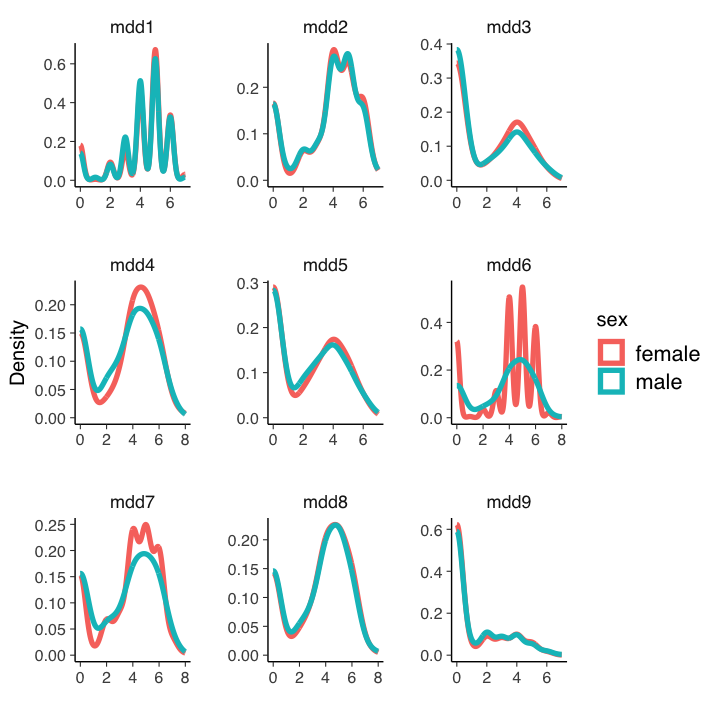

In [45]:
d_long <- d |>
    pivot_longer(!sex, names_to = "item", values_to = "value")

d_long |>
    ggplot(aes(value, col=sex)) +
    geom_density(linewidth=1.5) +
    facet_wrap(~item, nrow=3, scales="free") +
    labs(x=" ", y="Density")

I due gruppi considerati corrispondono al genere. Il problema riguarda l'invarianza fattoriale in funzione del genere. Consideriamo il seguente modello:

In [5]:
model_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 +
         mdd9
  mdd1 ~~ mdd2
"

Si noti la presenza di una correlazione residua tra gli indicatori `mdd1` e `mdd2`.

Esaminiamo dunque di seguito le varie forme di invarianza fattoriale. Si notino i vincoli che vengono via via introdotti quando vengono specificati modelli via via più restrittivi. Nella sintassi `lavaan` i vincoli vengono specificati dall'argomento `group.equal`.

Le forme di invarianza fattoriale qui verificate sono leggermente diverse da quelle elencate sopra.

In [6]:
# configural invariance
fit_ef <- cfa(
  model_mdd,
  data = d,
  group = "sex",
  meanstructure = TRUE
)
# plus equal factor loadings- metric invariance
fit_efl <- update(
  fit_ef,
  group.equal = c("loadings")
)
# plus equal indicator intercepts
fit_eii <- update(
  fit_efl,
  group.equal = c("loadings", "intercepts")
)
# plus equal indicator error variances
fit_eir <- update(
  fit_eii,
  group.equal = c("loadings", "intercepts", "residuals")
)
# plus equal factor variances
fit_fv <- update(
  fit_eir,
  group.equal = c(
    "loadings", "intercepts", "residuals",
    "lv.variances"
  )
)
# plus equal latent means
fit_fm <- update(
  fit_fv,
  group.equal = c(
    "loadings", "intercepts", "residuals",
    "lv.variances", "means"
  )
)

Confrontiamo i modelli:

In [7]:
out = lavTestLRT(fit_ef, fit_efl, fit_eii, fit_eir, fit_fv, fit_fm)
print(out)


Chi-Squared Difference Test

        Df   AIC   BIC   Chisq Chisq diff    RMSEA Df diff Pr(>Chisq)
fit_ef  52 27526 27784  98.911                                       
fit_efl 60 27514 27736 102.839     3.9286 0.000000       8     0.8635
fit_eii 68 27510 27695 115.309    12.4699 0.038600       8     0.1314
fit_eir 77 27502 27645 125.021     9.7115 0.014520       9     0.3743
fit_fv  78 27501 27639 125.814     0.7931 0.000000       1     0.3732
fit_fm  79 27501 27635 127.734     1.9201 0.049533       1     0.1659


Il confronto tra i precedenti modelli nidificati che introducono vincoli sempre più stringenti sui parametri indica che non vi è una "significativa" perdita di bontà dell'adattamento passando dal modello congenerico al modello che assume l'uguaglianza delle saturazioni fattoriali, delle intercette, delle varianze residue, delle varianze delle variabili latenti e delle medie dei due gruppi. Per i dati discussi da {cite:t}`brown2015confirmatory`, dunque, possiamo concludere che vi sono forti evidenze di invarianza fattoriale tra maschi e femmine in relazione al costrutto di depressione maggiore. L'invarianza fattoriali giustifica, per questi dati, un confronto tra le medie dei punteggi totali del test calcolate nei due gruppi.


## Indicatori a livello di scala ordinale

I test di invarianza fattoriale per i dati ordinali sono diversi da quelli utilizzati con le variabili continue per due aspetti: differiscono sia per lo stimatore che viene utilizzato per la stima delle saturazioni fattoriali, sia per il tipo di analisi statistiche che vengono svolte. 

Le variabili ordinali sono costituite da una serie di modalità (opzioni di risposta) caratterizzate da un ordine logico; ad esempio, le modalità "fortemente in disaccordo" fino a "fortemente d'accordo"; oppure le modalità "mai", "a volte", "spesso", "sempre". Queste opzioni di risposta sono logicamente ordinate e, per convenzione, ad esse vengono assegnati valori numerici interi. Tuttavia, poiché le risposte ordinali non descrivono l'intensità della presenza di un attributo, l'assegnazione di numeri alle risposte ordinali è arbitraria. Ad esempio, alle stesse cinque opzioni di risposta ordinate possiamo assegnare valori da 0 a 4, da 1 a 5, o da 5 a 1. Pertanto, i dati ordinali non possono essere analizzati come
se fossero continui: nel caso di dati ordinali, le medie, le varianze e le covarianze delle variabili non hanno significato. 

Un primo problema da affrontare è quello di come si possono calcolare le correlazioni per variabili di questo tipo. La risposta a questa domanda viene fornita dalle correlazioni policoriche. Le correlazioni policoriche si calcolano ipotizzando che vi sia una variabile continua latente normalmente distribuita che è responsabile delle frequenze osservate delle varie modalità di ciascuna variabile ordinali. Secondo questa ipotesi, ogni valore di risposta ordinale (es, "spesso") corrisponde ai valori della variabile continua latente sottostante compresi in un determinato intervallo di valori. Tali soglie, o cutoff, ($\tau_1, \tau_2, \dots, \tau_k$) sono concepite come dei margini verticali che suddividono l'area sottesa alla funzione di densità della distribuzione normale sottostante in $k$ sezioni, ciascuna delle quali corrisponde alla frequenza del punteggio ordinale che è stato osservato in quella categoria di risposta.

Se le correlazioni tra variabili ordinali sono stimate mediante le correlazioni policoriche, allora, nel contesto dell'invarianza fattoriale, un primo problema è quello dell'invarianza delle soglie (*treshold invariance*), la quale assume che le soglie necessarie per definire le correlazioni policoriche siano invarianti tra i gruppi. 

Un secondo aspetto specifico che riguarda lo studio dell'invarianza fattoriale nel caso di variabili ordinali riguarda lo stimatore da usare per la stima delle saturazioni fattoriali.  Lo stimatore attualmente consigliato per i dati ordinali è quello dei *minimi quadrati ponderati* (*Weighted least squares, WLS*). 

### Un esempio concreto

{cite:t}`wu2016identification` ritengono che la procedura per la valutazione dell'invarianza fattoriale che è stata descritta in precedenza (per dati continui) debba essere modificata se vogliamo applicarla a indicatori categoriali. La procedura usuale consiste nel definire prima un modello di riferimento e successivamente di imporre restrizioni crescenti ai parametri. Secondo {cite:t}`wu2016identification`, tale approccio non è ottimale nel caso di dati categoriali perché dipende fortemente dal modo in cui vengono definite le soglie necessarie per definire le correlazioni policoriche assegnate alle variabili continue latenti nel modello dell'invarianza configurale. Secondo {cite:t}`wu2016identification`, dunque, è prima necessario valutare l'equivalenza delle soglie tra gruppi (*threshold model*) e poi valutare il modello che ipotizza l'equivalenza delle saturazioni fattoriali tra i gruppi.

Per illustrare tale procedura, replichiamo qui il tutorial messo a punto da {cite:t}`svetina2020multiple`. Questi autori utilizzano quattro item di una scala del bullismo ed esaminano i dati raccolti in tre paesi (31 = Azerbaigian; 40 = Austria; 246 = Finlandia). Tutti gli item sono misurati su una scala di tipo Likert a 4 punti, che va da 0 (mai) a 3 (almeno una volta alla settimana). Gli item chiedono al partecipante di valutare delle affermazioni relative ad episodi di bullismo. Per esempio, "mi prendevano in giro o mi insultavano". Per l'Azerbaigian, l'Austria e la Finlandia, le dimensioni del campione sono rispettivamente pari a 3,808, 4,457 e 4,520. 

Leggiamo in dati in $\textsf{R}$:

In [8]:
dat <- read.table("data/BULLY.dat", header = FALSE)
names(dat) <- c("IDCNTRY", "R09A", "R09B", "R09C", "R09D")
head(dat)

,IDCNTRY,R09A,R09B,R09C,R09D
,<int>,<int>,<int>,<int>,<int>
1,31,3,3,0,0
2,31,0,0,0,0
3,31,3,2,1,3
4,31,0,0,3,0
5,31,0,0,0,0
6,31,0,0,0,0


Viene creata la matrice `all.results` per immagazzinare i risultati dei diversi modelli che verranno confrontati, chiamati _baseline_ (nessun vincolo tra i gruppi), _proposition 4_ (equivalenza delle soglie tra i gruppi), e _proposition 7_ (equivalenza delle soglie e delle saturazioni fattoriali tra i gruppi). Gli indici di bontà dell'adattamento che verranno considerati sono: chi-square, df, p, RMSEA, CFI, e TLI. 

In [9]:
all.results <- matrix(NA, ncol = 6, nrow = 3)

### Baseline model

Nel _baseline model_ non viene posto alcun vincolo tra i gruppi. È quello dell'invarianza configurale.

In [10]:
mod.cat <- "F1 =~ R09A + R09B + R09C + R09D"

In [11]:
baseline <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = "configural"
)

Informazioni sul modello baseline si ottengono nel modo seguente:

In [12]:
out = summary(baseline)
print(out)

This lavaan model syntax specifies a CFA with 4 manifest indicators (4 of which are ordinal) of 1 common factor(s).

To identify the location and scale of each common factor, the factor means and variances were fixed to 0 and 1, respectively, unless equality constraints on measurement parameters allow them to be freed.

The location and scale of each latent item-response underlying 4 ordinal indicators were identified using the "delta" parameterization, and the identification constraints recommended by Wu & Estabrook (2016). For details, read:

	https://doi.org/10.1007/s11336-016-9506-0 

Pattern matrix indicating num(eric), ord(ered), and lat(ent) indicators per factor:

     F1 
R09A ord
R09B ord
R09C ord
R09D ord

The following types of parameter were constrained to equality across groups:

	configural

     F1   
R09A "ord"
R09B "ord"
R09C "ord"
R09D "ord"


Le proprietà del modello possono essere esplicitate con la seguente istruzione:

In [13]:
cat(as.character(baseline))

## LOADINGS:

F1 =~ c(NA, NA, NA)*R09A + c(lambda.1_1.g1, lambda.1_1.g2, lambda.1_1.g3)*R09A
F1 =~ c(NA, NA, NA)*R09B + c(lambda.2_1.g1, lambda.2_1.g2, lambda.2_1.g3)*R09B
F1 =~ c(NA, NA, NA)*R09C + c(lambda.3_1.g1, lambda.3_1.g2, lambda.3_1.g3)*R09C
F1 =~ c(NA, NA, NA)*R09D + c(lambda.4_1.g1, lambda.4_1.g2, lambda.4_1.g3)*R09D

## THRESHOLDS:

R09A | c(NA, NA, NA)*t1 + c(R09A.thr1.g1, R09A.thr1.g2, R09A.thr1.g3)*t1
R09A | c(NA, NA, NA)*t2 + c(R09A.thr2.g1, R09A.thr2.g2, R09A.thr2.g3)*t2
R09A | c(NA, NA, NA)*t3 + c(R09A.thr3.g1, R09A.thr3.g2, R09A.thr3.g3)*t3
R09B | c(NA, NA, NA)*t1 + c(R09B.thr1.g1, R09B.thr1.g2, R09B.thr1.g3)*t1
R09B | c(NA, NA, NA)*t2 + c(R09B.thr2.g1, R09B.thr2.g2, R09B.thr2.g3)*t2
R09B | c(NA, NA, NA)*t3 + c(R09B.thr3.g1, R09B.thr3.g2, R09B.thr3.g3)*t3
R09C | c(NA, NA, NA)*t1 + c(R09C.thr1.g1, R09C.thr1.g2, R09C.thr1.g3)*t1
R09C | c(NA, NA, NA)*t2 + c(R09C.thr2.g1, R09C.thr2.g2, R09C.thr2.g3)*t2
R09C | c(NA, NA, NA)*t3 + c(R09C.thr3.g1, R09C.thr3.g2, R09C.thr3.g3)

Per potere essere passato a `lavaan`, l'oggetto `baseline` deve essere in formato `char`:

In [14]:
model.baseline <- as.character(baseline)

Adattiamo il modello ai dati:

In [15]:
fit.baseline <- cfa(
  model.baseline, 
  data = dat, 
  group = "IDCNTRY", 
  ordered = c("R09A", "R09B", "R09C", "R09D")
)

Salviamo i risultati:

In [16]:
all.results[1, ] <-
  round(
    data.matrix(
      fitmeasures(fit.baseline, fit.measures = c(
        "chisq.scaled", "df.scaled", "pvalue.scaled",
        "rmsea.scaled", "cfi.scaled", "tli.scaled"
      ))
    ),
    digits = 3
  )

### Invarianza delle soglie

Consideriamo ora il modello _threshold invariance_ [chiamato _Proposition 4_ da @wu2016identification]. 

In [17]:
prop4 <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = c("thresholds")
)

Adattiamo il modello ai dati:

In [18]:
model.prop4 <- as.character(prop4)
fit.prop4 <- cfa(
  model.prop4,
  data = dat,
  group = "IDCNTRY",
  ordered = c("R09A", "R09B", "R09C", "R09D")
)

Salviamo i risulati

In [19]:
#store model fit information for proposition 4
all.results[2, ] <-
  round(data.matrix(
  fitmeasures(fit.prop4,fit.measures = c(
    "chisq.scaled","df.scaled","pvalue.scaled", 
    "rmsea.scaled", "cfi.scaled", "tli.scaled"))), 
  digits=3
  )

Eseguiamo il confronto tra il modello _threshold invariance_ e il modello _baseline_:

In [20]:
lavTestLRT(fit.baseline, fit.prop4)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.baseline,6,NA,NA,26.94149,NA,NA,NA
fit.prop4,14,NA,NA,42.16983,61.01121,8,2.950764e-10


### Invarianza delle soglie e delle saturazioni fattoriali

Consideriamo ora il modello _threshold and loading invariance_ [chiamato _Proposition 7_ da @wu2016identification]. 

In [21]:
prop7 <- measEq.syntax(
  configural.model = mod.cat,
  data = dat,
  ordered = c("R09A", "R09B", "R09C", "R09D"),
  parameterization = "delta",
  ID.fac = "std.lv",
  ID.cat = "Wu.Estabrook.2016",
  group = "IDCNTRY",
  group.equal = c("thresholds", "loadings")
)

Adattiamo il modello ai dati:

In [22]:
model.prop7 <- as.character(prop7)
fit.prop7 <- cfa(
  model.prop7, 
  data = dat, group = "IDCNTRY", 
  ordered = c("R09A", "R09B", "R09C", "R09D")
  )

Salviamo i risultati:

In [24]:
all.results[3, ] <-
  round(data.matrix(
    fitmeasures(fit.prop7, fit.measures = c(
      "chisq.scaled", "df.scaled", "pvalue.scaled",
      "rmsea.scaled", "cfi.scaled", "tli.scaled"
    ))
  ), digits = 3)

column.names <-
  c(
    "chisq.scaled", "df.scaled", "pvalue.scaled", "rmsea.scaled",
    "cfi.scaled", "tli.scaled"
  )

row.names <- c("baseline", "prop4", "prop7")

colnames(all.results) <- column.names
rownames(all.results) <- row.names

Eseguiamo i confronti tra modelli:

In [25]:
lavTestLRT(fit.prop4, fit.prop7)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.prop4,14,NA,NA,42.16983,NA,NA,NA
fit.prop7,20,NA,NA,93.11534,73.70792,6,7.079865e-14


In [26]:
lavTestLRT(fit.prop7, fit.baseline)

,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
fit.baseline,6,NA,NA,26.94149,NA,NA,NA
fit.prop7,20,NA,NA,93.11534,136.1424,14,4.139318e-22


Un confronto tra gli indici di bontà di adattamento dei tre modelli è fornito di seguito:

In [27]:
print(all.results)

         chisq.scaled df.scaled pvalue.scaled rmsea.scaled cfi.scaled
baseline       50.944         6             0        0.042      0.997
prop4         107.839        14             0        0.040      0.994
prop7         186.542        20             0        0.044      0.989
         tli.scaled
baseline      0.991
prop4         0.992
prop7         0.990


In conclusione, nel caso presente, il test del rapporto di verosimiglianza indica che non viene rispettata neppure l'invarianza delle soglie tra gruppi. Gli altri confronti, dunque, sono superflui e sono stati qui presentati solo allo scopo di illustrare la procedura.





